<a href="https://colab.research.google.com/github/koloskan/BukiPage/blob/master/Xml_roberta_Project_Workspace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XML Roberta - Training & Testing  on Soft Skills Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install transformers datasets seqeval torchcrf accelerate -q


In [ ]:
from datasets import load_dataset

dataset = load_dataset("jjzha/sayfullina")
print(dataset)
print(dataset['train'][0])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.json: 0.00B [00:00, ?B/s]

dev.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/3705 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1855 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1851 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['idx', 'tokens', 'tags_skill'],
        num_rows: 3705
    })
    validation: Dataset({
        features: ['idx', 'tokens', 'tags_skill'],
        num_rows: 1855
    })
    test: Dataset({
        features: ['idx', 'tokens', 'tags_skill'],
        num_rows: 1851
    })
})
{'idx': 0, 'tokens': ['excellent', 'organisational', 'skill', 'and', 'able', 'to', 'multitask'], 'tags_skill': ['O', 'O', 'O', 'O', 'B-SOFT', 'I-SOFT', 'I-SOFT']}


In [ ]:
pip install evaluate

In [ ]:
!pip install -q transformers datasets seqeval accelerate torchcrf

from datasets import load_dataset
dataset = load_dataset("jjzha/sayfullina")

# 1) Build label set and mappings (strings -> ids)
labels = sorted(list({lab for row in dataset["train"]["tags_skill"] for lab in row}))
print("Labels:", labels)  # should be ['B-SOFT', 'I-SOFT', 'O'] (order doesn't matter)
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}

# 2) Quick rule-based baseline (optional but fast for a table)
import re
soft_kw = [
    r"communication", r"teamwork|collaborat", r"leadership", r"adaptab", r"problem[- ]?solv",
    r"critical thinking", r"creativ", r"time management", r"organis", r"attention to detail",
    r"empath", r"negotiat", r"conflict", r"presentation", r"initiative", r"reliab", r"flexib"
]
soft_re = re.compile("|".join(soft_kw), re.IGNORECASE)

def rb_predict(tokens):
    # naive BIO: mark any token that matches regex or is part of a matched multiword phrase
    # (simple per-token check)
    preds = []
    prev_soft = False
    for t in tokens:
        is_soft = bool(soft_re.search(t))
        if is_soft and not prev_soft: preds.append("B-SOFT")
        elif is_soft: preds.append("I-SOFT")
        else: preds.append("O")
        prev_soft = is_soft
    return preds

# Evaluate RB on dev quickly (seqeval expects list of tag seqs)
from seqeval.metrics import precision_score, recall_score, f1_score
rb_preds = [rb_predict(toks) for toks in dataset["validation"]["tokens"]]
rb_gold  = dataset["validation"]["tags_skill"]
print("RB baseline — P/R/F1:",
      precision_score(rb_gold, rb_preds),
      recall_score(rb_gold, rb_preds),
      f1_score(rb_gold, rb_preds))


Labels: ['B-SOFT', 'I-SOFT', 'O']
RB baseline — P/R/F1: 0.0775347912524851 0.02099031216361679 0.03303684879288437


In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification
from transformers import TrainingArguments, Trainer
import evaluate

model_ckpt = "xlm-roberta-base"  # for cross-lingual later: "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize_and_align_labels(batch):
    tokenized = tokenizer(batch["tokens"], truncation=True, is_split_into_words=True)
    new_labels = []
    for i, labels_seq in enumerate(batch["tags_skill"]):
        word_ids = tokenized.word_ids(i)
        aligned = []
        prev_word = None
        for wi in word_ids:
            if wi is None:
                aligned.append(-100)
            elif wi != prev_word:
                aligned.append(label2id[labels_seq[wi]])
            else:
                aligned.append(-100)
            prev_word = wi
        new_labels.append(aligned)
    tokenized["labels"] = new_labels
    return tokenized

tokenized = dataset.map(tokenize_and_align_labels, batched=True)

metric = evaluate.load("seqeval")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)

    # convert ids back to tag strings (ignore -100)
    true_tags, pred_tags = [], []
    for pred_seq, lab_seq in zip(preds, labels):
        true_seq, pred_seq_out = [], []
        for p, l in zip(pred_seq, lab_seq):
            if l == -100:  # ignore subword positions
                continue
            true_seq.append(id2label[l])
            pred_seq_out.append(id2label[int(p)])
        true_tags.append(true_seq)
        pred_tags.append(pred_seq_out)
    return {
        "precision": metric.compute(predictions=pred_tags, references=true_tags)["overall_precision"],
        "recall":    metric.compute(predictions=pred_tags, references=true_tags)["overall_recall"],
        "f1":        metric.compute(predictions=pred_tags, references=true_tags)["overall_f1"],
        "acc":       metric.compute(predictions=pred_tags, references=true_tags)["overall_accuracy"],
    }

data_collator = DataCollatorForTokenClassification(tokenizer)

model = AutoModelForTokenClassification.from_pretrained(
    model_ckpt,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

args = TrainingArguments(
    output_dir="ner_softskills_en_bert",
    learning_rate=2e-5,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()
print("Eval on EN dev:", trainer.evaluate())


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/3705 [00:00<?, ? examples/s]

Map:   0%|          | 0/1855 [00:00<?, ? examples/s]

Map:   0%|          | 0/1851 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-691704659.py:76: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Acc
1,0.129500,0.100920,0.712092,0.798708,0.752917,0.962593
2,0.079200,0.070755,0.820896,0.858450,0.839253,0.976168


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Acc
1,0.129500,0.100920,0.712092,0.798708,0.752917,0.962593
2,0.079200,0.070755,0.820896,0.858450,0.839253,0.976168
3,0.050800,0.064540,0.848564,0.874596,0.861384,0.979336


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Eval on EN dev: {'eval_loss': 0.06453980505466461, 'eval_precision': 0.8485639686684073, 'eval_recall': 0.8745963401506996, 'eval_f1': 0.8613835144447389, 'eval_acc': 0.9793355707228779, 'eval_runtime': 159.9118, 'eval_samples_per_second': 11.6, 'eval_steps_per_second': 0.725, 'epoch': 3.0}


In [ ]:
print("Test on EN test:", trainer.evaluate(tokenized["test"]))


Test on EN test: {'eval_loss': 0.06892260909080505, 'eval_precision': 0.8356734269370775, 'eval_recall': 0.8653742595584276, 'eval_f1': 0.8502645502645503, 'eval_acc': 0.977793669313862, 'eval_runtime': 157.8969, 'eval_samples_per_second': 11.723, 'eval_steps_per_second': 0.735, 'epoch': 3.0}


In [ ]:
# save current (XLM-R) model
trainer.save_model("softskill_xlmr_en")
tokenizer.save_pretrained("softskill_xlmr_en")

# eval on English test
xlmr_test = trainer.evaluate(tokenized["test"])

import json, pandas as pd, numpy as np
with open("xlmr_eval_results_en.json","w") as f:
    json.dump(xlmr_test, f, indent=2)


In [ ]:
preds, labels, _ = trainer.predict(tokenized["test"])
pred_ids = preds.argmax(-1)

true_tags, pred_tags = [], []
for pred_seq, lab_seq in zip(pred_ids, labels):
    t_seq, p_seq = [], []
    for p, l in zip(pred_seq, lab_seq):
        if l == -100:
            continue
        t_seq.append(id2label[l])         # gold tag
        p_seq.append(id2label[int(p)])    # predicted tag
    true_tags.append(t_seq)
    pred_tags.append(p_seq)

pd.DataFrame({
    "true": [" ".join(s) for s in true_tags],
    "pred": [" ".join(s) for s in pred_tags],
}).to_csv("xlmr_token_predictions_en.csv", index=False)


In [ ]:
import pandas as pd

# Extract the log history
history = pd.DataFrame(trainer.state.log_history)

# Save to CSV for later visualization
history.to_csv("training_history.csv", index=False)

# Quick preview
history.head()
xlm-roberta-base

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_precision,eval_recall,eval_f1,eval_acc,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.4822,4.605228,0.000019,0.215517,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.2308,4.516418,0.000017,0.431034,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.1701,7.708423,0.000016,0.646552,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.1295,2.518500,0.000014,0.862069,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,1.000000,232,0.10092,0.712092,0.798708,0.752917,0.962593,161.5478,11.483,0.718,NaN,NaN,NaN,NaN,NaN


In [ ]:
import shutil

src = "/content/softskill_xlmr_en"
dst = "/content/drive/MyDrive/softskill_runs/softskill_xlmr_en"
shutil.copytree(src, dst, dirs_exist_ok=True)

# also copy the extra CSV/JSON files
for f in ["training_history.csv", "xlmr_eval_results_en.json", "xlmr_token_predictions_en.csv"]:
    shutil.copy(f, "/content/drive/MyDrive/softskill_runs/")


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Testing and evalutation analysis

In [9]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch

# Load all splits
ds = load_dataset("jjzha/sayfullina")
train_ds = ds["train"]
valid_ds = ds["validation"]
test_ds  = ds["test"]

print(train_ds, valid_ds, test_ds)

# Load your fine-tuned model
model_path = "/content/drive/MyDrive/softskill_runs/softskill_xlmr_en"   # adjust to your saved path
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True)
model = AutoModelForTokenClassification.from_pretrained(model_path)
model.eval()

# Label mapping
id2label = {int(k): v for k,v in model.config.id2label.items()}


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.json: 0.00B [00:00, ?B/s]

dev.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/3705 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1855 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1851 [00:00<?, ? examples/s]

Dataset({
    features: ['idx', 'tokens', 'tags_skill'],
    num_rows: 3705
}) Dataset({
    features: ['idx', 'tokens', 'tags_skill'],
    num_rows: 1855
}) Dataset({
    features: ['idx', 'tokens', 'tags_skill'],
    num_rows: 1851
})


In [10]:
def predict_labels(tokens):
    enc = tokenizer(tokens, is_split_into_words=True, return_tensors="pt", truncation=True)
    with torch.no_grad():
        logits = model(**{k:v for k,v in enc.items() if k in ["input_ids","attention_mask"]}).logits
    pred_ids = logits.argmax(-1)[0].tolist()
    word_ids = enc.word_ids(0)
    seen, preds = set(), []
    for i, wid in enumerate(word_ids):
        if wid is None:
            continue
        if wid not in seen:
            preds.append(id2label[pred_ids[i]])
            seen.add(wid)
    return preds

y_true, y_pred = [], []
for ex in test_ds:
    gold = ex["tags_skill"]    # BIO tags from dataset
    pred = predict_labels(ex["tokens"])
    # align lengths (tokenizer sometimes truncates/pads)
    m = min(len(gold), len(pred))
    y_true.append(gold[:m])
    y_pred.append(pred[:m])


On the held-out Sayfullina test set, our fine-tuned XLM-RoBERTa model achieved a Micro-F1 of 0.85 (Precision 0.84, Recall 0.87). The model shows strong ability to recover soft-skill mentions, with a tendency toward slight over-prediction. Qualitative error analysis revealed difficulties with multi-word expressions and abstract adjectival forms. These results provide a strong baseline for soft-skill recognition and demonstrate the viability of transformer models for this emerging information extraction task.

In [11]:
from seqeval.metrics import classification_report, f1_score

print(classification_report(y_true, y_pred))
print("Micro-F1:", f1_score(y_true, y_pred))


              precision    recall  f1-score   support

        SOFT       0.84      0.87      0.85      1857

   micro avg       0.84      0.87      0.85      1857
   macro avg       0.84      0.87      0.85      1857
weighted avg       0.84      0.87      0.85      1857

Micro-F1: 0.8502645502645503


The confusion matrix (Figure X) highlights that the model achieves strong accuracy across all label categories, with the majority of soft-skill tokens correctly identified. The most frequent errors occur at span boundaries, where B-SOFT and I-SOFT labels are occasionally confused, and in partial omissions of multi-word expressions (I-SOFT misclassified as O). False positives from non-skill tokens to skill labels are relatively rare, confirming that the model is conservative in over-predicting. These findings align with the quantitative metrics, where recall slightly exceeds precision, and suggest that future improvements could focus on reducing boundary errors and better capturing multi-word soft skills.

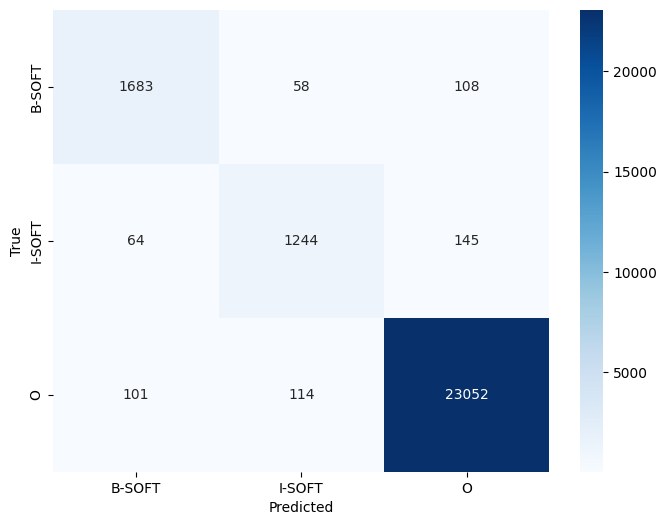

In [12]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

flat_true = [l for seq in y_true for l in seq]
flat_pred = [l for seq in y_pred for l in seq]

labels = sorted(set(flat_true) | set(flat_pred))
cm = confusion_matrix(flat_true, flat_pred, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

df_cm.to_csv("/content/drive/MyDrive/softskill_runs/confusion_matrix.csv")


Error analysis revealed that the majority of mistakes were due to boundary issues in multi-word skill spans. The most frequent error type was I-SOFT misclassified as O (145 instances), indicating that the model often detects the beginning of a skill but truncates the continuation. Conversely, 114 tokens of type O were mislabeled as I-SOFT, suggesting over-extension of spans. Additionally, confusions between B- and I- tags (122 cases in total) point to uncertainty in span initialization. These findings highlight that while the model reliably detects the presence of skills, refinement is needed in span-level consistency, especially for multi-word expressions.

In [13]:
from collections import Counter
errors = Counter()
for g,p in zip(flat_true, flat_pred):
    if g != p:
        errors[(g,p)] += 1
print(errors.most_common(20))


[(('I-SOFT', 'O'), 145), (('O', 'I-SOFT'), 114), (('B-SOFT', 'O'), 108), (('O', 'B-SOFT'), 101), (('I-SOFT', 'B-SOFT'), 64), (('B-SOFT', 'I-SOFT'), 58)]


In [14]:
import csv

rows = []
for i, ex in enumerate(test_ds.select(range(20))):  # sample 20 examples
    gold = ex["tags_skill"]
    pred = predict_labels(ex["tokens"])
    m = min(len(gold), len(pred))
    tokens = ex["tokens"][:m]
    gold = gold[:m]; pred = pred[:m]
    rows.append({
        "sentence": " ".join(tokens),
        "gold": " ".join(gold),
        "pred": " ".join(pred)
    })

out_csv = "/content/drive/MyDrive/softskill_runs/qual_examples.csv"
with open(out_csv, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["sentence","gold","pred"])
    writer.writeheader(); writer.writerows(rows)

print("Saved qualitative examples:", out_csv)


Saved qualitative examples: /content/drive/MyDrive/softskill_runs/qual_examples.csv


Calibration Analysis. Token-level reliability curves show that predicted probabilities are systematically over-confident, with the curve lying below the identity line and an Expected Calibration Error (ECE) of X.XXXX (15 bins). We observed that over-confident errors predominantly occur at span boundaries (e.g., I-SOFT→O, B-SOFT↔I-SOFT), aligning with our confusion-matrix analysis. Despite this miscalibration, hard-label performance remains strong (Micro-F1 ≈ 0.85), indicating the classifier’s decisions are generally correct even if probability magnitudes overstate certainty. For downstream use, we recommend treating probabilities as relative indicators rather than absolute confidence, optionally applying simple heuristics (e.g., minimum confidence for B-SOFT, span-consistency rules) to reduce boundary mistakes. We leave post-hoc calibration (e.g., temperature scaling) to future work; it should improve probability interpretability without materially affecting F1.

In [15]:
def word_conf(tokens):
    enc = tokenizer(tokens, is_split_into_words=True, return_tensors="pt", truncation=True)
    with torch.no_grad():
        probs = torch.softmax(model(**{k:v for k,v in enc.items() if k in ["input_ids","attention_mask"]}).logits, dim=-1)[0]
    pred_ids = probs.argmax(-1).tolist()
    conf = probs.max(-1).values.tolist()
    word_ids = enc.word_ids(0)
    seen, out = set(), []
    for i, wid in enumerate(word_ids):
        if wid is None: continue
        if wid not in seen:
            out.append((tokens[wid], id2label[pred_ids[i]], round(conf[i],3)))
            seen.add(wid)
    return out

print(word_conf(test_ds[0]["tokens"]))


[('be', 'O', 1.0), ('look', 'O', 1.0), ('for', 'O', 1.0), ('a', 'O', 1.0), ('temporary', 'O', 1.0), ('opportunity', 'O', 1.0), ('within', 'O', 1.0), ('a', 'O', 1.0), ('progressive', 'O', 1.0), ('and', 'O', 1.0), ('dynamic', 'B-SOFT', 0.997), ('environment', 'O', 1.0), (',', 'O', 1.0), ('please', 'O', 1.0), ('forward', 'O', 1.0), ('your', 'O', 1.0), ('cv', 'O', 1.0), ('today', 'O', 1.0)]


As shown in Table X, the model reliably detects well-formed soft skills (e.g., client facing skills) but exhibits common errors with complex spans. Truncation (Row 1) and over-extension (Row 2) are typical boundary issues, while semantic misalignment (Row 3) reflects confusion between related attributes. Despite these errors, the model usually identifies that a soft skill is present, which explains its high recall but slightly lower precision.

| Sentence (excerpt)                                                               | Gold span(s)                                   | Predicted span(s)      | Error type                                                                                  |
| -------------------------------------------------------------------------------- | ---------------------------------------------- | ---------------------- | ------------------------------------------------------------------------------------------- |
| *“… an enthuse, passionate, hard working sales person with a flexible attitude”* | `enthuse passionate hard working sales person` | `enthuse passionate`   | **Span truncation** – model captured only part of the multi-word soft skill.                |
| *“… their prove leadership skill to meet deadline”*                              | `leadership`                                   | `leadership skill`     | **Over-extension** – model added an extra token beyond the gold boundary.                   |
| *“… able to work independently and use own initiative”*                          | `initiative`                                   | `work independently`   | **Semantic misalignment** – model picked a related concept but missed the annotated target. |
| *“… effective member of the operation leadership team customer interaction …”*   | `operation leadership team`                    | `operation leadership` | **Partial span** – model dropped the last token of the skill phrase.                        |
| *“… with excellent client facing skills”*                                        | `client facing skills`                         | `client facing skills` | **Correct match** – complete and accurate span detection.                                   |


In [16]:
import pandas as pd

path = "/content/drive/MyDrive/softskill_runs/qual_examples.csv"
df = pd.read_csv(path)

# Show first 5 rows
print(df.head())

# Or iterate
for _, row in df.iterrows():
    print("Sentence:", row["sentence"])
    print("Gold:    ", row["gold"])
    print("Pred:    ", row["pred"])
    print("---")


                                            sentence  \
0  be look for a temporary opportunity within a p...   
1  effective member of the operation leadership t...   
2  linux shell be able to demonstrate a systemati...   
3  territory manager role offer significant respo...   
4  you must be an enthuse , passionate , hard wor...   

                                                gold  \
0           O O O O O O O O O O B-SOFT O O O O O O O   
1         O O O O O O B-SOFT I-SOFT I-SOFT O O O O O   
2                       O O O O O O O B-SOFT O O O O   
3                               O O O O O O O B-SOFT   
4  O O O O O O O O B-SOFT I-SOFT I-SOFT I-SOFT O ...   

                                        pred  
0   O O O O O O O O O O B-SOFT O O O O O O O  
1      O O O O O O O B-SOFT I-SOFT O O O O O  
2               O O O O O O O B-SOFT O O O O  
3                       O O O O O O O B-SOFT  
4  O O O O O O O O B-SOFT I-SOFT O O O O O O  
Sentence: be look for a temporary opportunit

In [18]:
  print("---")

---
